In [150]:
import numpy as np
from collections import Counter
import csv
from sklearn.preprocessing import LabelEncoder
import time
import matplotlib.pyplot as plt
import ga_eval
import itertools
from matplotlib import cm
import random
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import struct
import seaborn as sns
from sklearn.model_selection import train_test_split

## Datasets

Labeled examples:

In [2]:
with open('labeled-examples.csv', newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
#fix first target
data[0][0]='0'

In [3]:
X,y = [],[]
for i in range(len(data)):
    X.append([float(data[i][1]),float(data[i][2])])
    y.append(int(data[i][0]))

In [4]:
len(X)

1000

In [5]:
for i in range(10): print(X[i])

[0.00090003, 0.602762]
[0.00183046, 0.519435]
[0.00241566, 0.73422]
[0.00255716, 0.357847]
[0.00354946, 0.90909]
[0.00574744, 0.804348]
[0.00593913, 0.689691]
[0.00629783, 0.0751743]
[0.00635004, 0.480862]
[0.00736451, 0.40563]


In [6]:
print(y[0:10])

[0, 0, 0, 1, 0, 0, 0, 0, 0, 1]


Glass Identification

In [7]:
with open('glass.csv', newline='') as f:
    reader = csv.reader(f)
    gdata = list(reader)
#fix first target
gdata[0][0]='1'

In [8]:
Xg,yg = [],[]
for i in range(len(gdata)):
    Xg.append([float(gdata[i][1]),float(gdata[i][2]),float(gdata[i][3]),float(gdata[i][4]),
               float(gdata[i][5]),float(gdata[i][6]),float(gdata[i][7]),float(gdata[i][8]),
               float(gdata[i][9])])
    yg.append(int(gdata[i][10]))
for i in range(10): print(Xg[i],yg[i])

[1.52101, 13.64, 4.49, 1.1, 71.78, 0.06, 8.75, 0.0, 0.0] 1
[1.51761, 13.89, 3.6, 1.36, 72.73, 0.48, 7.83, 0.0, 0.0] 1
[1.51618, 13.53, 3.55, 1.54, 72.99, 0.39, 7.78, 0.0, 0.0] 1
[1.51766, 13.21, 3.69, 1.29, 72.61, 0.57, 8.22, 0.0, 0.0] 1
[1.51742, 13.27, 3.62, 1.24, 73.08, 0.55, 8.07, 0.0, 0.0] 1
[1.51596, 12.79, 3.61, 1.62, 72.97, 0.64, 8.07, 0.0, 0.26] 1
[1.51743, 13.3, 3.6, 1.14, 73.09, 0.58, 8.17, 0.0, 0.0] 1
[1.51756, 13.15, 3.61, 1.05, 73.24, 0.57, 8.24, 0.0, 0.0] 1
[1.51918, 14.04, 3.58, 1.37, 72.08, 0.56, 8.3, 0.0, 0.0] 1
[1.51755, 13.0, 3.6, 1.36, 72.99, 0.57, 8.4, 0.0, 0.11] 1


Banknote Authentication

In [9]:
with open('data_banknote_authentication.csv', newline='') as f:
    reader = csv.reader(f)
    bdata = list(reader)

In [10]:
Xb,yb = [],[]
for i in range(len(bdata)):
    Xb.append([float(bdata[i][0]),float(bdata[i][1]),float(bdata[i][2]),float(bdata[i][3])])
    yb.append(int(bdata[i][4]))
for i in range(10): print(Xb[i],yb[i])

[3.6216, 8.6661, -2.8073, -0.44699] 0
[4.5459, 8.1674, -2.4586, -1.4621] 0
[3.866, -2.6383, 1.9242, 0.10645] 0
[3.4566, 9.5228, -4.0112, -3.5944] 0
[0.32924, -4.4552, 4.5718, -0.9888] 0
[4.3684, 9.6718, -3.9606, -3.1625] 0
[3.5912, 3.0129, 0.72888, 0.56421] 0
[2.0922, -6.81, 8.4636, -0.60216] 0
[3.2032, 5.7588, -0.75345, -0.61251] 0
[1.5356, 9.1772, -2.2718, -0.73535] 0


In [11]:
class KNN:
    '''
    k-Nearest Neighbor Algorithm class.
    k is the number of Neighbors,
    if store_mode parameter is "errors", method only stores the first k points of each class
        any other value would store all instances through training
    metric parameter can only be "euclidan" or "manhattan"
    '''
    def __init__(self, k, store_mode, metric="euclidean"):
        self.k = k
        self.store_mode = store_mode
        self.X = None
        self.y = None
        self.le = LabelEncoder()
        self.metric = metric
    
    def fit(self, X, y):
        self.X = np.array(X)
        #The sklearn LabelEncoder function transforms the target values
        self.y = self.le.fit_transform(y)
        #Storing the training instances, all vs errors
        if self.store_mode == 'errors':
            self.X, self.y = self._store_errors(self.X, self.y)
    
    def predict(self, X_test):
        y_pred = []
        X_test = np.array(X_test)
        for x in X_test:
            #Distance metrics, euclidean (default) vs manhattan
            if self.metric == "euclidean":
                distances = np.sum((self.X - x)**2, axis=1)
            elif self.metric == "manhattan":
                distances = np.sum(np.abs(self.X - x), axis=1)
            else:
                print("Invalid metric parameter. Only euclidean and manhattan are available")
                break
            nearest_indices = np.argsort(distances)[:self.k]
            nearest_labels = self.y[nearest_indices]
            y_pred.append(Counter(nearest_labels).most_common(1)[0][0])
        return self.le.inverse_transform(y_pred)
    
    def _store_errors(self, X, y):
        X_stored = []
        y_stored = []
        class_counts = {}
        for x, label in zip(X, y):
            if label not in class_counts:
                class_counts[label] = 0
                X_stored.append(x)
                y_stored.append(label)
            else:
                if class_counts[label] < self.k:
                    class_counts[label] += 1
                    X_stored.append(x)
                    y_stored.append(label)
                else:
                    y_pred = self.predict([x])[0]
                    if self.le.transform([y_pred])[0] != label:
                        X_stored.append(x)
                        y_stored.append(label)
        return np.array(X_stored), np.array(y_stored)
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = np.mean(y_pred == y_test)
        return accuracy

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=26)

In [13]:
Xg_train, Xg_test, yg_train, yg_test = train_test_split(Xg, yg, test_size=0.3, random_state=26)

In [14]:
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.3, random_state=26)

In [15]:
knn_all_5 = KNN(k=5, store_mode="all")
knn_all_5.fit(X_train, y_train)
pred_all_5 = knn_all_5.predict(X_test)

In [16]:
pred_all_5

array([0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1])

In [17]:
knn_all_5.score(X_test, y_test)

0.9566666666666667

In [18]:
knn_g_all_7_man = KNN(k=7, store_mode="all", metric="manhattan")
knn_g_all_7_man.fit(Xg_train, yg_train)
pred_g_all_7_man = knn_g_all_7_man.predict(Xg_test)

In [19]:
pred_g_all_7_man

array([7, 1, 3, 1, 1, 2, 1, 7, 7, 1, 7, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1,
       7, 2, 7, 5, 2, 7, 3, 3, 2, 5, 2, 5, 1, 2, 1, 2, 7, 1, 5, 1, 1, 2,
       1, 1, 1, 1, 2, 1, 3, 1, 1, 2, 1, 3, 5, 1, 2, 1, 5, 2, 2, 6, 1])

In [20]:
knn_g_all_7_man.score(Xg_test, yg_test)

0.5384615384615384

In [21]:
knn_b_all_11 = KNN(k=7, store_mode="all", metric="euclidean")
knn_b_all_11.fit(Xb_train, yb_train)
pred_b_all_11 = knn_b_all_11.predict(Xb_test)

In [22]:
pred_b_all_11

array([1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,

In [23]:
knn_b_all_11.score(Xb_test, yb_test)

1.0

In [24]:
def cross_validation(model, X, y, n_splits=5):
    n = len(X)
    chunk_size = n // n_splits
    acctrain = 0
    acctest = 0
    for i in range(n_splits):
        start = i * chunk_size
        end = (i + 1) * chunk_size
        X_test = X[start:end]
        y_test = y[start:end]
        X_train = np.concatenate([X[:start], X[end:]])
        y_train = np.concatenate([y[:start], y[end:]])
        model.fit(X_train, y_train)
        acctrain += model.score(X_train, y_train)
        acctest += model.score(X_test, y_test)
    acctrain /= n_splits
    acctest /= n_splits
    return acctrain, acctest

In [25]:
knn_err_5 = KNN(k=5, store_mode='errors')
# Call the cross_validation function
train_accuracy, test_accuracy = cross_validation(knn_err_5, np.asarray(X), np.asarray(y))
print("Train accuracy for k=5, store=errors: {:.2f}%".format(train_accuracy * 100))
print("Test accuracy for k=5, store=errors: {:.2f}%".format(test_accuracy * 100))

Train accuracy for k=5, store=errors: 52.33%
Test accuracy for k=5, store=errors: 52.60%


In [26]:
train_accuracy, test_accuracy = cross_validation(knn_g_all_7_man, np.asarray(Xg), np.asarray(yg))
print("Train accuracy for k=7 and metric=manhattan: {:.2f}%".format(train_accuracy * 100))
print("Test accuracy for k=7 and metric=manhattan: {:.2f}%".format(test_accuracy * 100))

Train accuracy for k=7 and metric=manhattan: 80.23%
Test accuracy for k=7 and metric=manhattan: 41.43%


Here we cross validate for different kNN setups based on k values (odd numbers from 1 to 21), storing options (store all instances or store first k errors of each class) and distance metrics (euclidean and manhattan). After testing each kNN, we plot the results.

In [27]:
# Define the range of k values to test
k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
store_modes = ['all', 'errors']
metrics = ['euclidean', 'manhattan']
results = []
for metric in metrics:
    for store_mode in store_modes:
        for k in k_values:
            model = KNN(k=k, store_mode=store_mode, metric=metric)
            start_time = time.time()
            train_acc, test_acc = cross_validation(model, np.asarray(X), np.asarray(y), n_splits=10)
            results.append({
                'k': k,
                'store_mode': store_mode,
                'metric': metric,
                'train_acc': train_acc,
                'test_acc': test_acc,
                'computation_time': time.time() - start_time})
            
for result in results:
    print("k: {:2d}  store_mode: {}  metric: {}  train_acc: {:.3f}  test_acc: {:.3f}  time: {:.3f}s"\
          .format(result['k'], result['store_mode'], result['metric'], result['train_acc'], result['test_acc'], result['computation_time']))

k:  1  store_mode: all  metric: euclidean  train_acc: 1.000  test_acc: 0.878  time: 0.715s
k:  3  store_mode: all  metric: euclidean  train_acc: 0.984  test_acc: 0.869  time: 0.663s
k:  5  store_mode: all  metric: euclidean  train_acc: 0.985  test_acc: 0.853  time: 0.669s
k:  7  store_mode: all  metric: euclidean  train_acc: 0.975  test_acc: 0.846  time: 0.664s
k:  9  store_mode: all  metric: euclidean  train_acc: 0.968  test_acc: 0.845  time: 0.672s
k: 11  store_mode: all  metric: euclidean  train_acc: 0.966  test_acc: 0.849  time: 0.672s
k: 13  store_mode: all  metric: euclidean  train_acc: 0.965  test_acc: 0.847  time: 0.671s
k: 15  store_mode: all  metric: euclidean  train_acc: 0.960  test_acc: 0.845  time: 0.676s
k: 17  store_mode: all  metric: euclidean  train_acc: 0.956  test_acc: 0.839  time: 0.676s
k: 19  store_mode: all  metric: euclidean  train_acc: 0.953  test_acc: 0.838  time: 0.683s
k: 21  store_mode: all  metric: euclidean  train_acc: 0.955  test_acc: 0.825  time: 0.677s

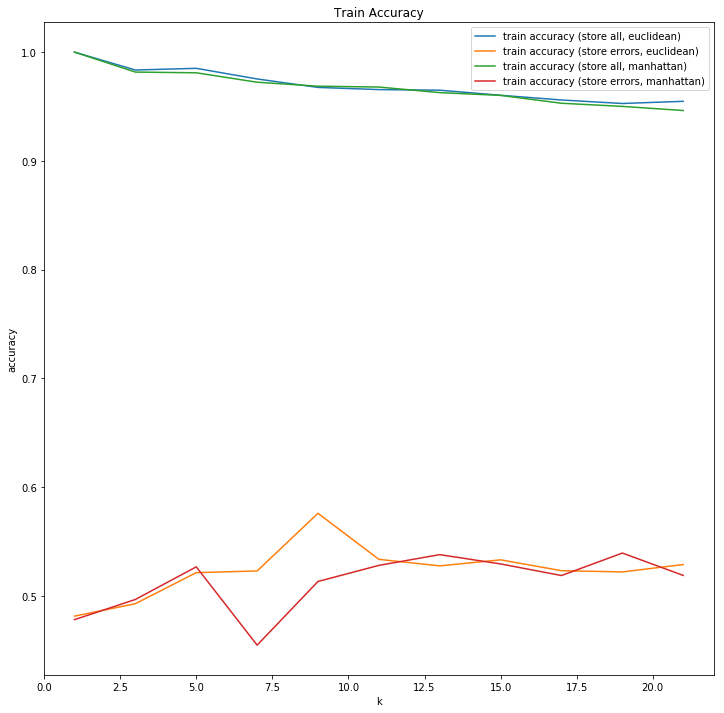

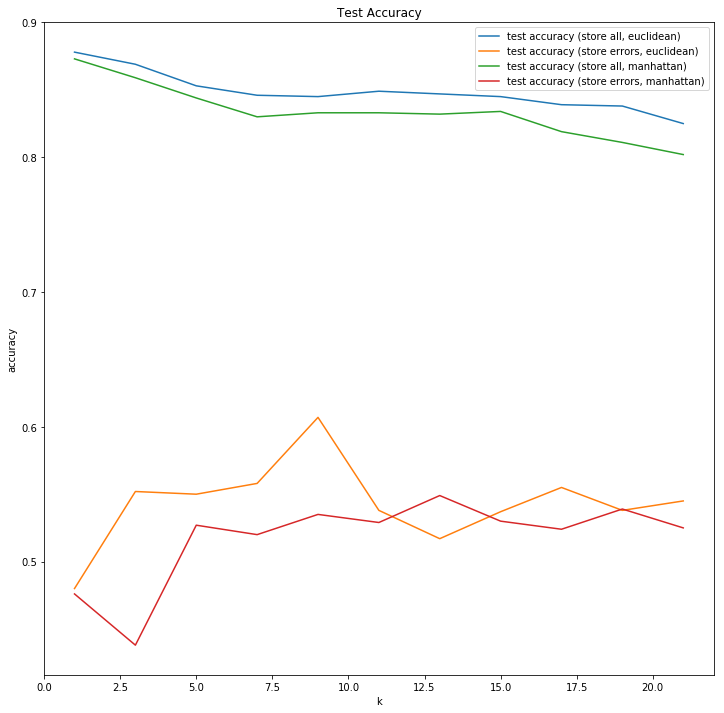

In [28]:
# extract accuracy results for each k value
train_acc_all_euc = [result["train_acc"] for result in results if result["store_mode"] == "all" and result["metric"] == "euclidean"]
test_acc_all_euc = [result["test_acc"] for result in results if result["store_mode"] == "all" and result["metric"] == "euclidean"]
train_acc_errors_euc = [result["train_acc"] for result in results if result["store_mode"] == "errors" and result["metric"] == "euclidean"]
test_acc_errors_euc = [result["test_acc"] for result in results if result["store_mode"] == "errors" and result["metric"] == "euclidean"]
train_acc_all_man = [result["train_acc"] for result in results if result["store_mode"] == "all" and result["metric"] == "manhattan"]
test_acc_all_man = [result["test_acc"] for result in results if result["store_mode"] == "all" and result["metric"] == "manhattan"]
train_acc_errors_man = [result["train_acc"] for result in results if result["store_mode"] == "errors" and result["metric"] == "manhattan"]
test_acc_errors_man = [result["test_acc"] for result in results if result["store_mode"] == "errors" and result["metric"] == "manhattan"]
#Take the first half of "k" values since they are repeated for 2 store_mode values
ks = [result["k"] for result in results][0:22]

#training
fig = plt.figure(figsize=(12,12))
plt.plot(ks[0:11], train_acc_all_euc, label="train accuracy (store all, euclidean)")
plt.plot(ks[0:11], train_acc_errors_euc, label="train accuracy (store errors, euclidean)")
plt.plot(ks[0:11], train_acc_all_man, label="train accuracy (store all, manhattan)")
plt.plot(ks[0:11], train_acc_errors_man, label="train accuracy (store errors, manhattan)")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.title("Train Accuracy")
plt.legend()
plt.show()
#test
fig = plt.figure(figsize=(12,12))
plt.plot(ks[11:22], test_acc_all_euc, label="test accuracy (store all, euclidean)")
plt.plot(ks[11:22], test_acc_errors_euc, label="test accuracy (store errors, euclidean)")
plt.plot(ks[11:22], test_acc_all_man, label="test accuracy (store all, manhattan)")
plt.plot(ks[11:22], test_acc_errors_man, label="test accuracy (store errors, manhattan)")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.title("Test Accuracy")
plt.legend()
plt.show()

Same cross validation settings applied to the glass identification dataset

In [29]:
# Define the range of k values to test
k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
store_modes = ['all', 'errors']
metrics = ['euclidean', 'manhattan']
results = []
for metric in metrics:
    for store_mode in store_modes:
        for k in k_values:
            model = KNN(k=k, store_mode=store_mode, metric=metric)
            start_time = time.time()
            train_acc, test_acc = cross_validation(model, np.asarray(Xg), np.asarray(yg), n_splits=10)
            results.append({
                'k': k,
                'store_mode': store_mode,
                'metric': metric,
                'train_acc': train_acc,
                'test_acc': test_acc,
                'computation_time': time.time() - start_time})

for result in results:
    print("k: {:2d}  store_mode: {}  metric: {}  train_acc: {:.3f}  test_acc: {:.3f}  time: {:.3f}s"\
          .format(result['k'], result['store_mode'], result['metric'], result['train_acc'], result['test_acc'], result['computation_time']))

k:  1  store_mode: all  metric: euclidean  train_acc: 1.000  test_acc: 0.529  time: 0.067s
k:  3  store_mode: all  metric: euclidean  train_acc: 0.867  test_acc: 0.495  time: 0.067s
k:  5  store_mode: all  metric: euclidean  train_acc: 0.815  test_acc: 0.510  time: 0.069s
k:  7  store_mode: all  metric: euclidean  train_acc: 0.777  test_acc: 0.490  time: 0.069s
k:  9  store_mode: all  metric: euclidean  train_acc: 0.755  test_acc: 0.438  time: 0.070s
k: 11  store_mode: all  metric: euclidean  train_acc: 0.718  test_acc: 0.443  time: 0.068s
k: 13  store_mode: all  metric: euclidean  train_acc: 0.686  test_acc: 0.467  time: 0.069s
k: 15  store_mode: all  metric: euclidean  train_acc: 0.678  test_acc: 0.462  time: 0.068s
k: 17  store_mode: all  metric: euclidean  train_acc: 0.685  test_acc: 0.452  time: 0.070s
k: 19  store_mode: all  metric: euclidean  train_acc: 0.681  test_acc: 0.448  time: 0.069s
k: 21  store_mode: all  metric: euclidean  train_acc: 0.673  test_acc: 0.438  time: 0.069s

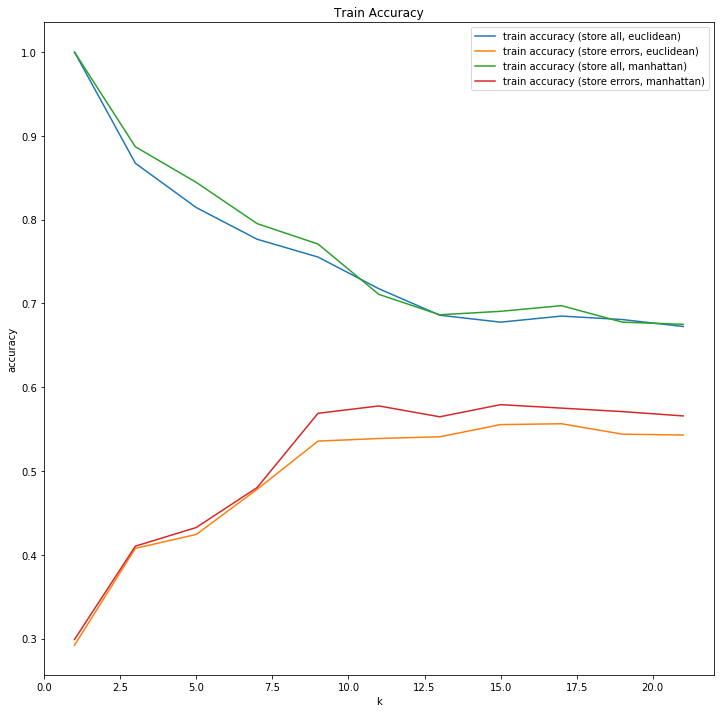

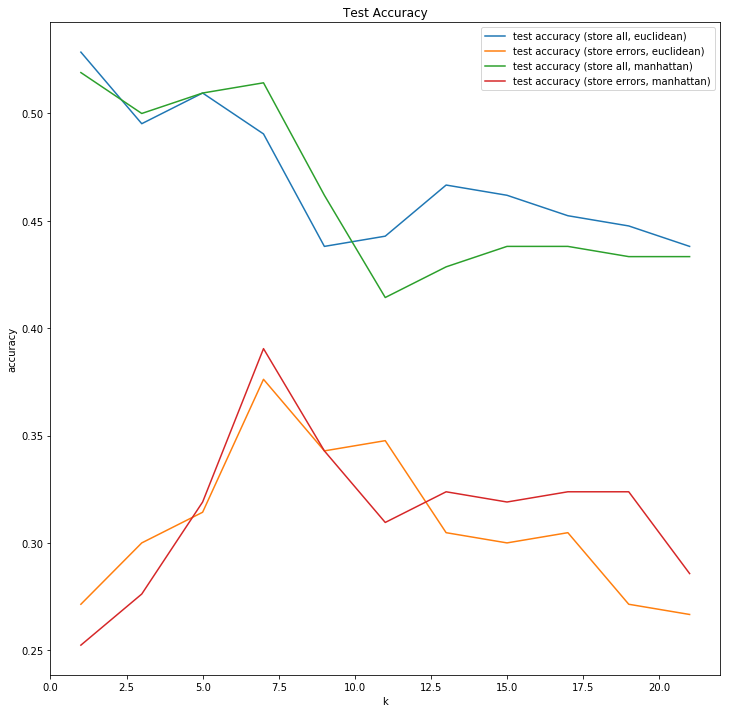

In [30]:
# extract accuracy results for each k value
train_acc_all_euc = [result["train_acc"] for result in results if result["store_mode"] == "all" and result["metric"] == "euclidean"]
test_acc_all_euc = [result["test_acc"] for result in results if result["store_mode"] == "all" and result["metric"] == "euclidean"]
train_acc_errors_euc = [result["train_acc"] for result in results if result["store_mode"] == "errors" and result["metric"] == "euclidean"]
test_acc_errors_euc = [result["test_acc"] for result in results if result["store_mode"] == "errors" and result["metric"] == "euclidean"]
train_acc_all_man = [result["train_acc"] for result in results if result["store_mode"] == "all" and result["metric"] == "manhattan"]
test_acc_all_man = [result["test_acc"] for result in results if result["store_mode"] == "all" and result["metric"] == "manhattan"]
train_acc_errors_man = [result["train_acc"] for result in results if result["store_mode"] == "errors" and result["metric"] == "manhattan"]
test_acc_errors_man = [result["test_acc"] for result in results if result["store_mode"] == "errors" and result["metric"] == "manhattan"]
#Take the first half of "k" values since they are repeated for 2 store_mode values
ks = [result["k"] for result in results][0:22]

#training
fig = plt.figure(figsize=(12,12))
plt.plot(ks[0:11], train_acc_all_euc, label="train accuracy (store all, euclidean)")
plt.plot(ks[0:11], train_acc_errors_euc, label="train accuracy (store errors, euclidean)")
plt.plot(ks[0:11], train_acc_all_man, label="train accuracy (store all, manhattan)")
plt.plot(ks[0:11], train_acc_errors_man, label="train accuracy (store errors, manhattan)")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.title("Train Accuracy")
plt.legend()
plt.show()
#test
fig = plt.figure(figsize=(12,12))
plt.plot(ks[11:22], test_acc_all_euc, label="test accuracy (store all, euclidean)")
plt.plot(ks[11:22], test_acc_errors_euc, label="test accuracy (store errors, euclidean)")
plt.plot(ks[11:22], test_acc_all_man, label="test accuracy (store all, manhattan)")
plt.plot(ks[11:22], test_acc_errors_man, label="test accuracy (store errors, manhattan)")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.title("Test Accuracy")
plt.legend()
plt.show()

In [31]:
# Define the range of k values to test
k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
store_modes = ['all', 'errors']
metrics = ['euclidean', 'manhattan']
results = []
for metric in metrics:
    for store_mode in store_modes:
        for k in k_values:
            model = KNN(k=k, store_mode=store_mode, metric=metric)
            start_time = time.time()
            train_acc, test_acc = cross_validation(model, np.asarray(Xb), np.asarray(yb), n_splits=10)
            results.append({
                'k': k,
                'store_mode': store_mode,
                'metric': metric,
                'train_acc': train_acc,
                'test_acc': test_acc,
                'computation_time': time.time() - start_time})

for result in results:
    print("k: {:2d}  store_mode: {}  metric: {}  train_acc: {:.3f}  test_acc: {:.3f}  time: {:.3f}s"\
          .format(result['k'], result['store_mode'], result['metric'], result['train_acc'], result['test_acc'], result['computation_time']))

k:  1  store_mode: all  metric: euclidean  train_acc: 1.000  test_acc: 0.999  time: 1.246s
k:  3  store_mode: all  metric: euclidean  train_acc: 0.999  test_acc: 0.999  time: 1.240s
k:  5  store_mode: all  metric: euclidean  train_acc: 1.000  test_acc: 1.000  time: 1.264s
k:  7  store_mode: all  metric: euclidean  train_acc: 1.000  test_acc: 1.000  time: 1.251s
k:  9  store_mode: all  metric: euclidean  train_acc: 1.000  test_acc: 1.000  time: 1.262s
k: 11  store_mode: all  metric: euclidean  train_acc: 1.000  test_acc: 1.000  time: 1.253s
k: 13  store_mode: all  metric: euclidean  train_acc: 1.000  test_acc: 1.000  time: 1.262s
k: 15  store_mode: all  metric: euclidean  train_acc: 0.999  test_acc: 0.998  time: 1.252s
k: 17  store_mode: all  metric: euclidean  train_acc: 0.998  test_acc: 0.994  time: 1.265s
k: 19  store_mode: all  metric: euclidean  train_acc: 0.997  test_acc: 0.993  time: 1.270s
k: 21  store_mode: all  metric: euclidean  train_acc: 0.995  test_acc: 0.993  time: 1.265s

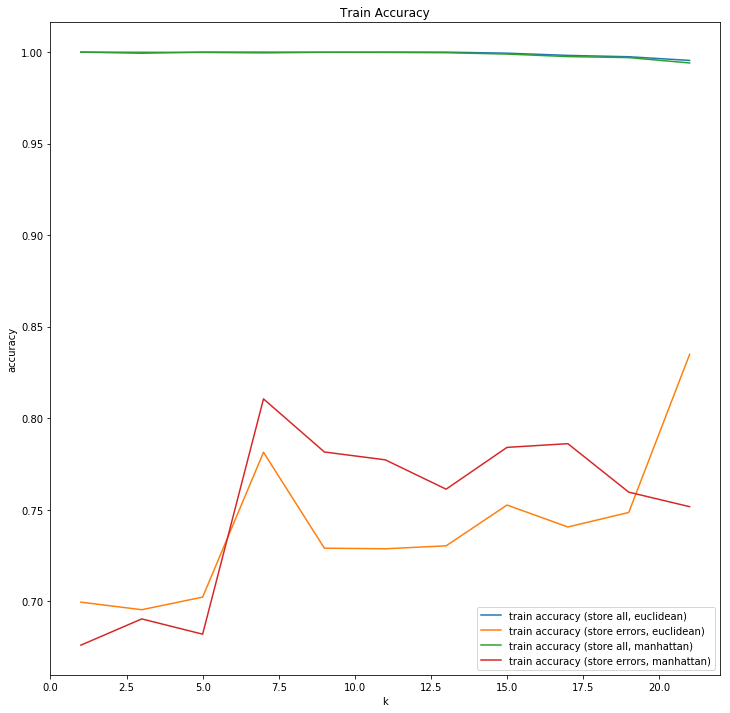

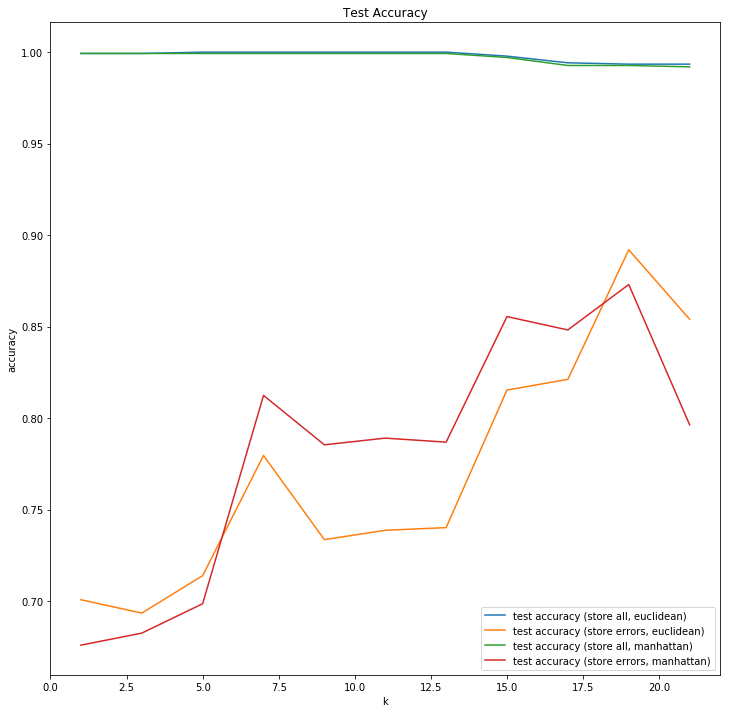

In [32]:
# extract accuracy results for each k value
train_acc_all_euc = [result["train_acc"] for result in results if result["store_mode"] == "all" and result["metric"] == "euclidean"]
test_acc_all_euc = [result["test_acc"] for result in results if result["store_mode"] == "all" and result["metric"] == "euclidean"]
train_acc_errors_euc = [result["train_acc"] for result in results if result["store_mode"] == "errors" and result["metric"] == "euclidean"]
test_acc_errors_euc = [result["test_acc"] for result in results if result["store_mode"] == "errors" and result["metric"] == "euclidean"]
train_acc_all_man = [result["train_acc"] for result in results if result["store_mode"] == "all" and result["metric"] == "manhattan"]
test_acc_all_man = [result["test_acc"] for result in results if result["store_mode"] == "all" and result["metric"] == "manhattan"]
train_acc_errors_man = [result["train_acc"] for result in results if result["store_mode"] == "errors" and result["metric"] == "manhattan"]
test_acc_errors_man = [result["test_acc"] for result in results if result["store_mode"] == "errors" and result["metric"] == "manhattan"]
#Take the first half of "k" values since they are repeated for 2 store_mode values
ks = [result["k"] for result in results][0:22]

#training
fig = plt.figure(figsize=(12,12))
plt.plot(ks[0:11], train_acc_all_euc, label="train accuracy (store all, euclidean)")
plt.plot(ks[0:11], train_acc_errors_euc, label="train accuracy (store errors, euclidean)")
plt.plot(ks[0:11], train_acc_all_man, label="train accuracy (store all, manhattan)")
plt.plot(ks[0:11], train_acc_errors_man, label="train accuracy (store errors, manhattan)")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.title("Train Accuracy")
plt.legend()
plt.show()
#test
fig = plt.figure(figsize=(12,12))
plt.plot(ks[11:22], test_acc_all_euc, label="test accuracy (store all, euclidean)")
plt.plot(ks[11:22], test_acc_errors_euc, label="test accuracy (store errors, euclidean)")
plt.plot(ks[11:22], test_acc_all_man, label="test accuracy (store all, manhattan)")
plt.plot(ks[11:22], test_acc_errors_man, label="test accuracy (store errors, manhattan)")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.title("Test Accuracy")
plt.legend()
plt.show()

## Part B. Local Search Algorithms

The two algorithms we implemented here are simulated annealing and genetic algorithm. The algorithms are designed by the following pseudocodes provided in Figure 4.5 and Figure 4.8, page 115 and 119 of the Russell & Norvig textbook (4th Edition) respectively:

```python
function SIMULATED-ANNEALING(problem, schedule) returns a solution state
    current ← problem.INITIAL
    for t = 1 to ∞ do
        T ← schedule(t)
        if T = 0 then return current
        next ← a randomly selected successor of current
        ∆E ← VALUE(current) – VALUE(next)
        if ∆E > 0 then current ← next
        else current ← next only with probability e**−∆E/T
```

```python
function GENETIC-ALGORITHM(population, fitness) returns an individual
    repeat
        weights ← WEIGHTED-BY(population, fitness)
        population2 ← empty list
        for i = 1 to SIZE(population) do
            parent1, parent2 ← WEIGHTED-RANDOM-CHOICES(population, weights, 2)
            child ← REPRODUCE(parent1, parent2)
            if (small random probability) then child ← MUTATE(child)
            add child to population2
        population ← population2
    until some individual is fit enough, or enough time has elapsed
    return the best individual in population, according to fitness

function REPRODUCE(parent1, parent2) returns an individual
    n ← LENGTH(parent1)
    c ← random number from 1 to n
    return APPEND(SUBSTRING(parent1, 1, c), SUBSTRING(parent2, c + 1, n))
```

### Simulated Annealing:

This function takes x and y maximum and minimum bounds created with the \_mesh() function provided in ga_eval.py file. A random point is selected inside the boundaries provided with X and Y matrices' maximum and minimum values. The Z values are calculated for current and next_candidate variables with the f function provided as a parameter. By comparing the Z values of two instances, the $\Delta E$ value is calculated. The schedule function adjust the temperature (T) by using the step count (t) in a linear fashion; as the loop progresses, the probability of taking a randomly selected worse step decreases.

In [243]:
def simulated_annealing(xmin, xmax, ymin, ymax, f, t=0, T_max=100000, maximize=True, verbose=False):
    '''
    Simulated Annealing function: takes X and Y max and min values (boundaries),
    f is the function call from the ga_eval.py and t is used by schedule
    to adjust the temperature (T) default is 0, if > T_max-1 (9999) function wont loop,
    T_max or maximum heat is a parameter to set to upper bound for temperature (T),
    current is initially created randomly in bounds of X and Y,
    t represents the step count and used to adjust T with schedule function,
    the for loop is infinite, algorithm stops when water freezes: T reaches 0. 
    maximize parameter modifies the fitness rule by multiplying fitness with -1 
    to find the minimum or maximum, True by default.
    '''
    if maximize == True: g = 1
    else: g = (-1)
    trace = []
    current = np.array([random.uniform(xmin, xmax), 
                        random.uniform(ymin, ymax)])
    best_sol = current
    best_val = f(current)*g
    if verbose == True: trace.append(best_sol)
    for t in itertools.count(1):
        #T value controls the finishing condition
        T = schedule(t, T_max)
        #print(T)
        if T <= 0:
            if verbose == True: return trace
            else: return best_sol
        #Next candidate is selected randomly inside the limits of X and Y
        next_candidate = np.array([min(xmax, max(xmin, current[0] + random.uniform(-1, 1))), 
                                   min(ymax, max(ymin, current[1] + random.uniform(-1, 1)))])
        delta_E = (f(current) - f(next_candidate))*g
        #If delta_E is positive, the next_candidate is better
        if delta_E > 0:
            current = next_candidate
            if f(current)*g > best_val:
                best_sol = current
                if verbose == True: trace.append(best_sol)
                best_val = f(current)*g
        #On the worse case, the possibility of random backwards step is calculated with the delta_E and T
        else:
            prob = math.exp(-delta_E/T)
            if random.uniform(0, 1) < prob:
                current = next_candidate
    if verbose == True: return trace
    else: return best_sol

def schedule(t, T_max):
    '''This function is implemented with the linear decrease'''
    return T_max-t

### Genetic Algorithm

This function is designed as an infinite loop with two stopping conditions; achieving a satisfying fitness or reaching the limit for the amount of new generations. The evolution count limit can be parameterized with T. The mutation probability can be adjusted with the mp argument, for no mutations, this parameter should be set to 1. The cross-over between the two fittest individuals is provided with the reproduce function, a random split is applied to achieve a new individual within the boundaries. Mutate function applies a random bit switch mutation to the individual, the resulting individual is always in bounds. Fitness function calls individual_fitness function to calculate fitness for each individual in given population. The fitness values are calculated with the given f argument.

In [213]:
def genetic_algorithm(population, f, threshold, xmin, xmax, ymin, ymax, T=100000, mp=0.05, maximize=True, verbose=False):
    '''
    Genetic Algorithm function, takes initial population,
    f is the function call from the ga_eval.py and threshold is the desired fitness lower bound,
    xmin, xmax, ymin and ymax are boundaries for the matrix and T is max number of evolution,
    mp is the mutation probability. maximize parameter modifies the fitness rule 
    by multiplying fitness with -1 to find the minimum or maximum, True by default.
    '''
    trace = []
    while True:
        #weights are fitness values scaled into 0-1
        weights = weighted_by(fitness(population, f, maximize))
        population2 = []
        for i in range(len(population)):
            parent1, parent2 = weighted_random_choices(population, weights, 2)
            child = reproduce(parent1, parent2, xmin, xmax, ymin, ymax)
            #Mutation with given probability, set mp parameter to 1 for no mutation
            if random.random() < mp:
                child = mutate(child, xmin, xmax, ymin, ymax)
            population2.append(child)
        best_sol = b2f(max(population, key=lambda x: individual_fitness(x, f, maximize)))
        best_val = f(np.asarray(best_sol))
        if verbose == True: trace.append(best_sol)
        population = population2
        T -= 1
        if any(individual_fitness(individual, f, maximize) >= threshold for individual in population) or T == 0:
            break
    if verbose == True: return trace
    else: return best_sol

def reproduce(parent1, parent2, xmin, xmax, ymin, ymax):
    #Cross-over function, boundaries are checked for each new child; if out of bounds, create new child
    n = len(parent1)
    while True:
        c = random.randint(1, n)
        child = parent1[:c] + parent2[c:]
        x, y = b2f(child)
        if xmin <= x <= xmax and ymin <= y <= ymax:
            break
    return child

def mutate(individual, xmin, xmax, ymin, ymax):
    #Mutation flips a random bit, boundaries are checked for each individual; if out of bounds, create new mutation
    while True:
        n = len(individual)
        i = random.randint(0, n - 1)
        individual = individual[:i] + str(1 - int(individual[i])) + individual[i + 1:]
        x, y = b2f(individual)
        if xmin <= x <= xmax and ymin <= y <= ymax:
            return individual

def individual_fitness(individual, f, maximize):
    if maximize == True: g = 1
    else: g = (-1)
    #Uses function f to calculate Z value for individual after conversion to X and Y
    return (g)*f(np.array(b2f(individual)))

def fitness(population, f, maximize):
    #Uses individual_fitness function to calculate the fitness values for population
    values = []
    for individual in population:
        i_f = individual_fitness(individual, f, maximize)
        values.append(i_f)
    return values

def weighted_by(a):
    #Scales the fitness values between 0 and 1
    weights = np.interp(a, (min(a), max(a)), (0, 1))
    return weights

def weighted_random_choices(population, weights, k):
    #Random choices with weights
    total_weight = sum(weights)
    indices = random.choices(range(len(population)), weights, k=k)
    return [population[index] for index in indices]

def initial_population(x_min, x_max, y_min, y_max, m):
    population = []
    for i in range(m):
        population.append(randomb(x_min, x_max, y_min, y_max))
    return population

### Utility functions

In [264]:
def plot_f(sol_s, f, xmin, xmax, ymin, ymax, v1=20, v2=30):
    '''Plots the 3d surface and the single result point in 3d plot
    sol_s is a single solution, X and Y coordinates
    v1 and v2 are camera angles for 3d plot'''
    X,Y = ga_eval._mesh(xmin, xmax, ymin, ymax)
    Z = np.zeros(np.asarray(X).shape)
    for i, j in itertools.product(range(X.shape[0]), range(X.shape[1])):
        Z[i, j] = f(np.array([X[i,j], Y[i,j]]))
    print("X and Y values of the solution: " + str(sol_s))
    print("Z value of the solution: " + str(f(sol_s)))
    print("Maximum found in mesh: " + str(Z.max()))
    print("Minimum found in mesh: " + str(Z.min()))
    fig = plt.figure(figsize=(12,12))
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, alpha=0.3)
    ax.scatter(sol_s[0], sol_s[1], f(sol_s), c='r', marker='o', s=35)
    ax.set_zlim(Z.min(), Z.max())
    ax.view_init(v1, v2)
    plt.show()
    
def plot_fs(sol_s, f, xmin, xmax, ymin, ymax, v1=20, v2=30):
    '''Plots the 3d surface and given results together in 3d plot
    sol_s is a list of solutions, X and Y coordinates
    v1 and v2 are camera angles for 3d plot
    Maximum numbers of solutions are limited to 7 (no. of named colors), can be increased'''
    c = ["r","g","b","k","m","c","y"]
    X,Y = ga_eval._mesh(xmin, xmax, ymin, ymax)
    Z = np.zeros(np.asarray(X).shape)
    for i, j in itertools.product(range(X.shape[0]), range(X.shape[1])):
        Z[i, j] = f(np.array([X[i,j], Y[i,j]]))
    fig = plt.figure(figsize=(12,12))
    ax = fig.gca(projection='3d')
    for i in range(len(sol_s)):
        print("X and Y values of " + str(i) + ". solution: " + str(sol_s[i]))
        print("Z value of " + str(i) + ". solution: " + str(f(np.array(sol_s[i]))))
        ax.scatter(sol_s[i][0], sol_s[i][1], f(sol_s[i]), c=c[i], marker='o', s=35)
    print("Maximum found in mesh: " + str(Z.max()))
    print("Minimum found in mesh: " + str(Z.min()))
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, alpha=0.3)
    ax.set_xlim((xmin,xmax))
    ax.set_ylim((ymin,ymax))
    ax.set_zlim(Z.min(), Z.max())
    ax.view_init(v1, v2)
    plt.show()

def plot_fs_sub(sol_s, f, xmin, xmax, ymin, ymax, v1=20, v2=30):
    c = ["r","g","b","k","m","c","y"]
    X,Y = ga_eval._mesh(xmin, xmax, ymin, ymax)
    Z = np.zeros(np.asarray(X).shape)
    for i, j in itertools.product(range(X.shape[0]), range(X.shape[1])):
        Z[i, j] = f(np.array([X[i,j], Y[i,j]]))
    print("Maximum found in mesh: " + str(Z.max()))
    print("Minimum found in mesh: " + str(Z.min()))
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    #ax.set_title("SA and GA maximize on Sphere")
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, alpha=0.3)
    ax.scatter(sol_s[0][0], sol_s[0][1], f(sol_s[0]), s=35, c='r', marker='o', alpha=1)
    ax.scatter(sol_s[1][0], sol_s[1][1], f(sol_s[1]), s=35, c='b', marker='o', alpha=1)
    ax.set_zlim(Z.min(), Z.max())
    ax.view_init(20, 60)
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    #ax.set_title("SA and GA minimize on Sphere")
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, alpha=0.3)
    ax.scatter(sol_s[2][0], sol_s[2][1], f(sol_s[2]), s=35, c='r', marker='o', alpha=1)
    ax.scatter(sol_s[3][0], sol_s[3][1], f(sol_s[3]), s=35, c='b', marker='o', alpha=1)
    ax.set_zlim(Z.min(), Z.max())
    ax.view_init(20, 60)
    plt.show()
    
def f2b(x, y):
    """Takes the X and Y coordinate values, converts these float values to bit string,
    and combines them to create bit string representation of an individual"""
    x_bits = struct.pack('!f', x)
    y_bits = struct.pack('!f', y)
    x_bits = "".join(format(a, "08b") for a in x_bits)
    y_bits = "".join(format(a, "08b") for a in y_bits)
    return x_bits + y_bits

def b2f(bit_string):
    """Takes the bit string and converts it to X and Y coordinate values,
    individual representation to X and Y values"""
    x = int(bit_string[:32], 2).to_bytes(4, byteorder="big")
    y = int(bit_string[32:], 2).to_bytes(4, byteorder="big")
    x_bits = struct.unpack("!f", x)[0]
    y_bits = struct.unpack("!f", y)[0]
    return np.array([x_bits, y_bits])

def randomb(x_min, x_max, y_min, y_max):
    """Creates a random individual with random bits
    Boundaries for the specific function adopted with min and max X and Y"""
    x = random.uniform(x_min, x_max)
    y = random.uniform(y_min, y_max)
    x_bits = struct.pack('!f', x)
    y_bits = struct.pack('!f', y)
    x_bits = "".join(format(a, "08b") for a in x_bits)
    y_bits = "".join(format(a, "08b") for a in y_bits)
    return x_bits + y_bits

def compare_methods(f, xmin, xmax, ymin, ymax, maximize, schedule=schedule, pop_size=5, v1=20, v2=20):
    """Compares Simulated Annealing and Genetic Algorithm results in the same plot"""
    X,Y = ga_eval._mesh(xmin, xmax, ymin, ymax)
    Z = np.zeros(np.asarray(X).shape)
    for i, j in itertools.product(range(X.shape[0]), range(X.shape[1])):
        Z[i, j] = f(np.array([X[i,j], Y[i,j]]))
    sa = simulated_annealing(xmin, xmax, ymin, ymax, f, schedule, maximize=maximize)
    population = initial_population(xmin, xmax, ymin, ymax, pop_size)
    ga = genetic_algorithm(population, f, f(sa)*0.95, xmin, xmax, ymin, ymax, maximize=maximize)
    plot_fs([sa, b2f(ga)], f, xmin, xmax, ymin, ymax, v1, v2)

Other functions:

In [393]:
def himmelblau(x):
    return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 -7)**2

def ackley(x):
    return -20.0 * np.exp(-0.2 * np.sqrt(0.5 * (x[0]**2 + x[1]**2))) - np.exp(0.5 * (np.cos(2 * np.pi * x[0]) + np.cos(2 * np.pi * x[1]))) + np.e + 20

def holders(x):
    return -abs(np.sin(x[0]) * np.cos(x[1]) * np.exp(abs(1 - (np.sqrt(x[0]**2 + x[1]**2)/np.pi))))

def sixcamelback(x):
    return ((4-2.1*x[0]**2+(x[0]**4)/3) * x[0]**2) + (x[0]*x[1]) + ((-4+4*x[1]**2) * x[1]**2)

The Sphere Function

In [251]:
xmin, xmax, ymin, ymax = -5, 5, -5, 5
sol_sa_sphere_min = simulated_annealing(xmin, xmax, ymin, ymax, ga_eval.sphere, t=0, maximize=False)
population = initial_population(xmin, xmax, ymin, ymax, 5)
sol_ga_sphere_min = genetic_algorithm(population, ga_eval.sphere, ga_eval.sphere(sol_sa_sphere)*0.95, xmin, xmax, ymin, ymax, maximize=False)
sol_sa_sphere_max = simulated_annealing(xmin, xmax, ymin, ymax, ga_eval.sphere, t=0, maximize=True)
population = initial_population(xmin, xmax, ymin, ymax, 5)
sol_ga_sphere_max = genetic_algorithm(population, ga_eval.sphere, ga_eval.sphere(sol_sa_sphere)*0.95, xmin, xmax, ymin, ymax, maximize=True)

In [266]:
print(ga_eval.sphere(sol_sa_sphere_max), ga_eval.sphere(sol_ga_sphere_max), ga_eval.sphere(sol_sa_sphere_min), ga_eval.sphere(sol_ga_sphere_min))

143.75135686815682 64.92053234915183 0.05465345176408264 0.25000008940697516


Maximum found in mesh: 144.0
Minimum found in mesh: 0.0


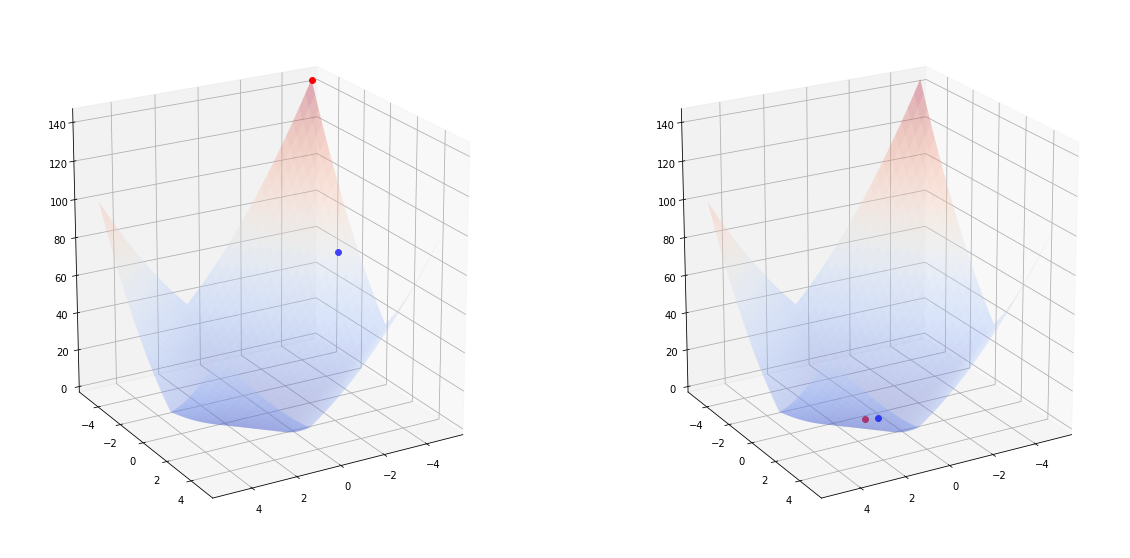

In [265]:
plot_fs_sub([sol_sa_sphere_max, sol_ga_sphere_max, sol_sa_sphere_min, sol_ga_sphere_min], ga_eval.sphere, xmin, xmax, ymin, ymax, 20, 35)

In [270]:
xmin, xmax, ymin, ymax = 0, 200, 0, 200
sol_sa_griew_min = simulated_annealing(xmin, xmax, ymin, ymax, ga_eval.griew, t=0, maximize=False)
population = initial_population(xmin, xmax, ymin, ymax, 5)
sol_ga_griew_min = genetic_algorithm(population, ga_eval.griew, ga_eval.griew(sol_sa_griew_max)*0.95, xmin, xmax, ymin, ymax, maximize=False)
sol_sa_griew_max = simulated_annealing(xmin, xmax, ymin, ymax, ga_eval.griew, t=0, maximize=True)
population = initial_population(xmin, xmax, ymin, ymax, 5)
sol_ga_griew_max = genetic_algorithm(population, ga_eval.griew, ga_eval.griew(sol_sa_griew_min)*0.95, xmin, xmax, ymin, ymax, maximize=True)

In [274]:
population = initial_population(xmin, xmax, ymin, ymax, 5)
sol_ga_griew_max2 = genetic_algorithm(population, ga_eval.griew, ga_eval.griew(sol_sa_griew_min)*0.95, xmin, xmax, ymin, ymax, maximize=True,  T=1000000)

In [276]:
(ga_eval.griew(sol_ga_griew_max2))

5.888691002854673

In [277]:
population = initial_population(xmin, xmax, ymin, ymax, 5)
sol_ga_griew_max3 = genetic_algorithm(population, ga_eval.griew, ga_eval.griew(sol_sa_griew_min)*0.95, xmin, xmax, ymin, ymax, maximize=True,  T=10000000)

In [278]:
(ga_eval.griew(sol_ga_griew_max3))

6.637262559410077

In [271]:
print(ga_eval.griew(sol_sa_griew_max), ga_eval.griew(sol_ga_griew_max), ga_eval.griew(sol_sa_griew_min), ga_eval.griew(sol_ga_griew_min))

10.275953076109024 4.7888910869750205 0.08649809223574145 0.14466641981597683


Maximum found in mesh: 11.409841565870167
Minimum found in mesh: 0.0


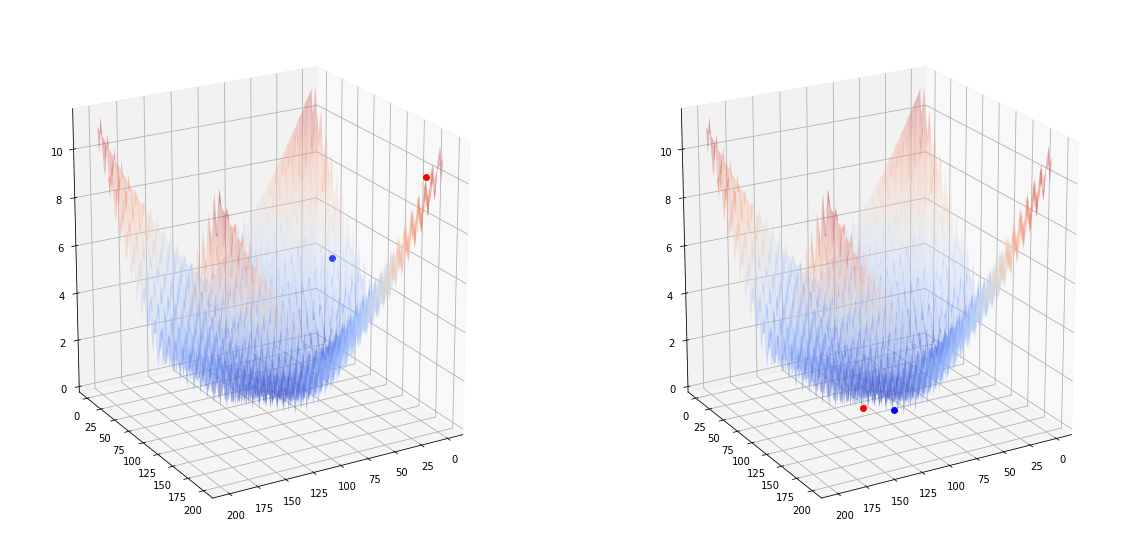

In [272]:
plot_fs_sub([sol_sa_griew_max, sol_ga_griew_max, sol_sa_griew_min, sol_ga_griew_min], ga_eval.griew, xmin, xmax, ymin, ymax, 20, 35)

In [290]:
xmin, xmax, ymin, ymax = 0, 10, 0, 10
sol_sa_shekel_min = simulated_annealing(xmin, xmax, ymin, ymax, ga_eval.shekel, t=0, maximize=False, T_max=1000000)
population = initial_population(xmin, xmax, ymin, ymax, 5)
sol_ga_shekel_min = genetic_algorithm(population, ga_eval.shekel, ga_eval.shekel(sol_sa_shekel_min)*0.95, xmin, xmax, ymin, ymax, maximize=False, T=1000000)

In [291]:
print(ga_eval.shekel(sol_sa_shekel_min), ga_eval.shekel(sol_ga_shekel_min))

-693.0702487699458 -6.630360737417964


X and Y values of 0. solution: [8.90214641 1.5051153 ]
Z value of 0. solution: -693.0702487699458
X and Y values of 1. solution: [1.91486216 6.16304255]
Z value of 1. solution: -6.630360737417964
Maximum found in mesh: -0.4086773875565976
Minimum found in mesh: -5103.449743333068


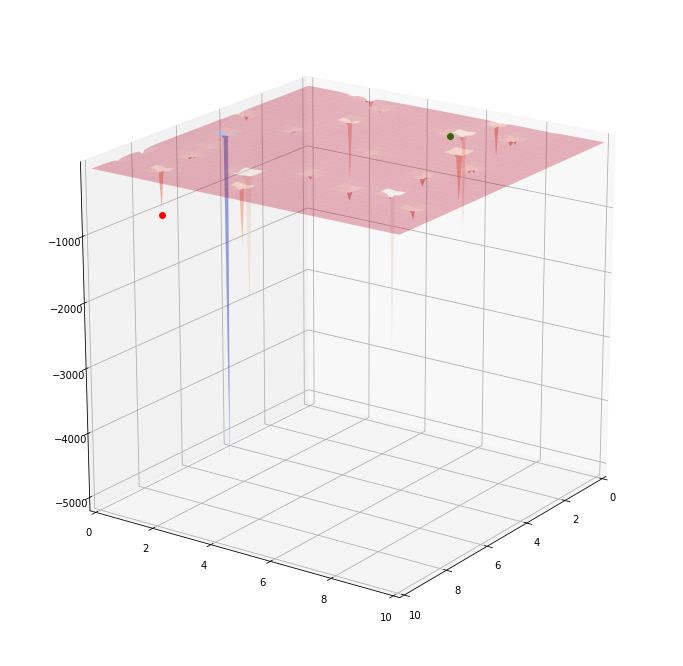

In [292]:
plot_fs([sol_sa_shekel_min, sol_ga_shekel_min], ga_eval.shekel, xmin, xmax, ymin, ymax, 20, 35)

In [302]:
xmin, xmax, ymin, ymax = -100, 100, -100, 100
sol_sa_micha_min = simulated_annealing(xmin, xmax, ymin, ymax, ga_eval.micha, t=0, maximize=False, T_max=1000000)
population = initial_population(xmin, xmax, ymin, ymax, 5)
sol_ga_micha_min = genetic_algorithm(population, ga_eval.micha, ga_eval.micha(sol_sa_micha_min)*0.95, xmin, xmax, ymin, ymax, maximize=False, T=1000000)
sol_sa_micha_max = simulated_annealing(xmin, xmax, ymin, ymax, ga_eval.micha, t=0, maximize=True)
population = initial_population(xmin, xmax, ymin, ymax, 5)
sol_ga_micha_max = genetic_algorithm(population, ga_eval.micha, ga_eval.micha(sol_sa_micha_max)*0.95, xmin, xmax, ymin, ymax, maximize=True)

In [303]:
print(ga_eval.micha(sol_sa_micha_max), ga_eval.micha(sol_ga_micha_max), ga_eval.micha(sol_sa_micha_min), ga_eval.micha(sol_ga_micha_min))

1.5783789571160147 1.4493341490809408 -1.4383023708980418 -0.38248285848440094


Maximum found in mesh: 1.7361159931585388
Minimum found in mesh: -1.7361159931585388


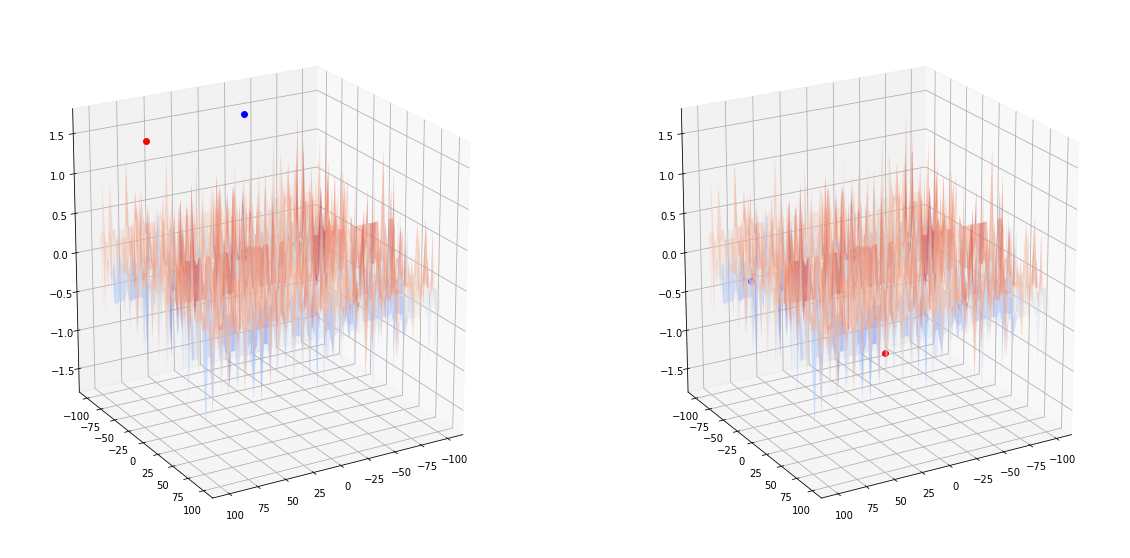

In [304]:
plot_fs_sub([sol_sa_micha_max, sol_ga_micha_max, sol_sa_micha_min, sol_ga_micha_min], ga_eval.micha, xmin, xmax, ymin, ymax, 20, 35)

In [307]:
xmin, xmax, ymin, ymax = 0, 10, 0, 10
sol_sa_langermann_min = simulated_annealing(xmin, xmax, ymin, ymax, ga_eval.langermann, t=0, maximize=False)
population = initial_population(xmin, xmax, ymin, ymax, 5)
sol_ga_langermann_min = genetic_algorithm(population, ga_eval.langermann, ga_eval.langermann(sol_sa_langermann_min)*0.95, xmin, xmax, ymin, ymax, maximize=False)

In [308]:
print(ga_eval.langermann(sol_sa_langermann_min), ga_eval.langermann(sol_ga_langermann_min))

-1.2920757867191819 -0.5213467520371432


X and Y values of 0. solution: [5.59429247 8.91531654]
Z value of 0. solution: -1.2920757867191819
X and Y values of 1. solution: [4.69258404 0.38962385]
Z value of 1. solution: -0.5213467520371432
Maximum found in mesh: 1.9543360987720315
Minimum found in mesh: -1.7035340699359796


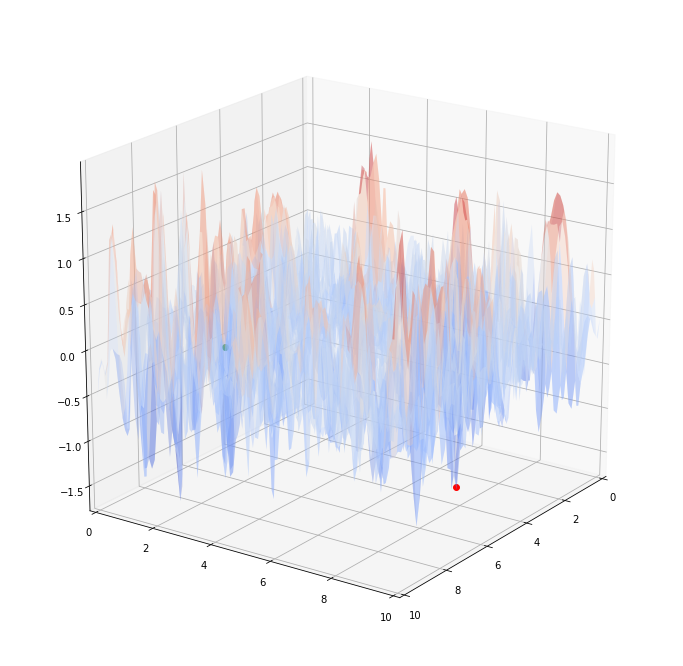

In [310]:
plot_fs([sol_sa_langermann_min, sol_ga_langermann_min], ga_eval.langermann, xmin, xmax, ymin, ymax, 20, 35)

In [312]:
xmin, xmax, ymin, ymax = -5*np.pi, 5*np.pi, -5*np.pi, 5*np.pi
sol_sa_odd_min = simulated_annealing(xmin, xmax, ymin, ymax, ga_eval.odd_square, t=0, maximize=False)
population = initial_population(xmin, xmax, ymin, ymax, 5)
sol_ga_odd_min = genetic_algorithm(population, ga_eval.odd_square, ga_eval.odd_square(sol_sa_odd_min)*0.95, xmin, xmax, ymin, ymax, maximize=False)
sol_sa_odd_max = simulated_annealing(xmin, xmax, ymin, ymax, ga_eval.odd_square, t=0, maximize=True)
population = initial_population(xmin, xmax, ymin, ymax, 5)
sol_ga_odd_max = genetic_algorithm(population, ga_eval.odd_square, ga_eval.odd_square(sol_sa_odd_max)*0.95, xmin, xmax, ymin, ymax, maximize=True)

In [315]:
print(ga_eval.odd_square(sol_sa_odd_max), ga_eval.odd_square(sol_ga_odd_max), ga_eval.odd_square(sol_sa_odd_min), ga_eval.odd_square(sol_ga_odd_min))

1.1294275551808375 0.8732426096152877 -1.0078952247940711 -1.5209793958952203e-09


Maximum found in mesh: 1.1366253311914372
Minimum found in mesh: -1.0222808073387684


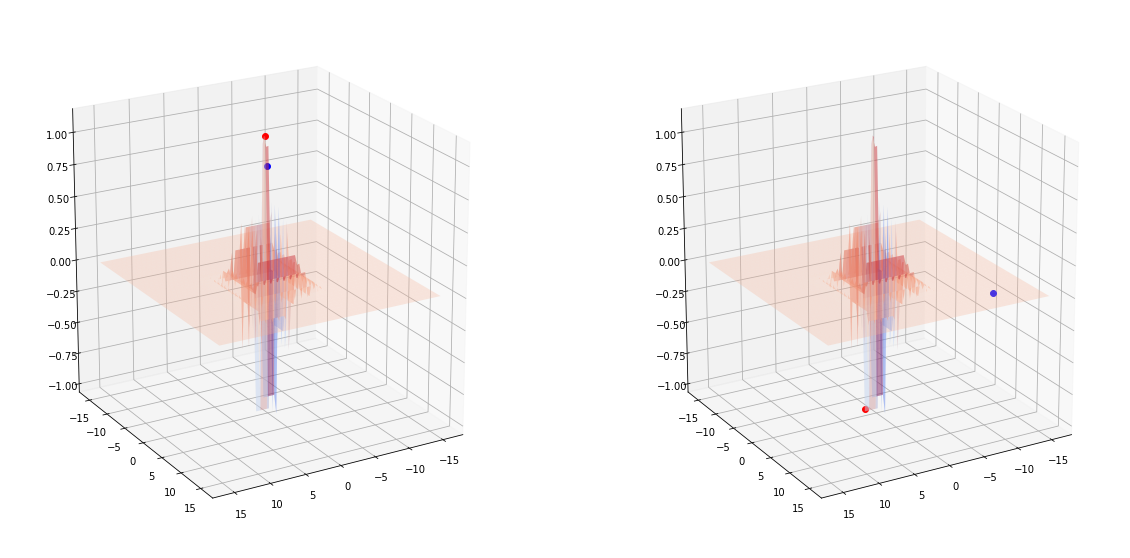

In [314]:
plot_fs_sub([sol_sa_odd_max, sol_ga_odd_max, sol_sa_odd_min, sol_ga_odd_min], ga_eval.odd_square, xmin, xmax, ymin, ymax, 20, 35)

In [217]:
xmin, xmax, ymin, ymax = 0.1, 5, 0.1, 5
trace_sa_bump = simulated_annealing(xmin, xmax, ymin, ymax, ga_eval.bump, T_max=10000, t=0, verbose=True)
population = initial_population(xmin, xmax, ymin, ymax, 5)
trace_ga_bump = genetic_algorithm(population, ga_eval.bump, ga_eval.bump(solbump)*0.95, xmin, xmax, ymin, ymax, T=10000, verbose=True)

In [218]:
xx,yy,zz,xg,yg,zg=[],[],[],[],[],[]
for i in range(len(trace_sa_bump)):
    xx.append(trace_sa_bump[i][0])
    yy.append(trace_sa_bump[i][1])
    zz.append(ga_eval.bump(trace_sa_bump[i]))
for i in range(len(trace_ga_bump)):
    xg.append(trace_ga_bump[i][0])
    yg.append(trace_ga_bump[i][1])
    zg.append(ga_eval.bump(trace_ga_bump[i]))

In [225]:
print(zz)

[0.08754639689795204, 0.12044983221847291, 0.14677422134215587, 0.28948900699371993, 0.5012532881942476, 0.6439989719396559]


In [223]:
print(zg[0:5])
print(zg[-5:])

[0.13541345378321534, 0.13541345378321534, 0.13544568758476563, 0.13544568758476563, 0.13544568758476563]
[0.6082099574320079, 0.6082099574320079, 0.6082099574320079, 0.6082099574320079, 0.6082099574320079]


Maximum found in mesh: 0.6558704376336668
Minimum found in mesh: 0.0


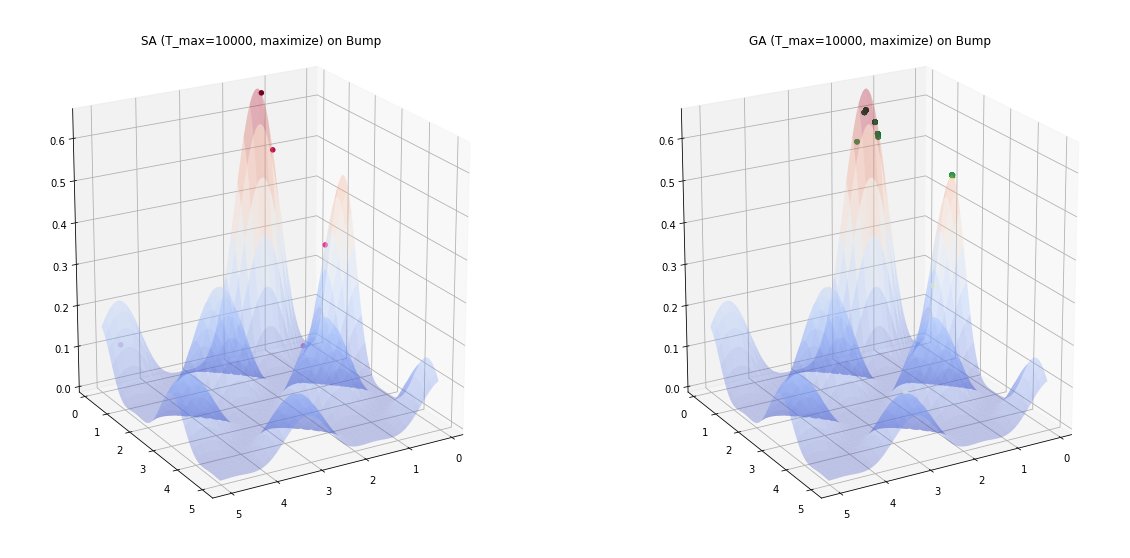

In [220]:
# Create Map
X,Y = ga_eval._mesh(xmin, xmax, ymin, ymax)
Z = np.zeros(np.asarray(X).shape)
for i, j in itertools.product(range(X.shape[0]), range(X.shape[1])):
    Z[i, j] = ga_eval.bump(np.array([X[i,j], Y[i,j]]))
print("Maximum found in mesh: " + str(Z.max()))
print("Minimum found in mesh: " + str(Z.min()))
fig = plt.figure(figsize=(20,10))
col1 = np.arange(len(xx))
col2 = np.arange(len(xg))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_title("SA (T_max=10000, maximize) on Bump")
#ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, alpha=0.3)
ax.scatter(xx, yy, zz, c=col1, cmap='PuRd', marker='o', alpha=1)
ax.set_zlim(Z.min(), Z.max())
ax.view_init(20, 60)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_title("GA (T_max=10000, maximize) on Bump")
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, alpha=0.3)
ax.scatter(xg, yg, zg, c=col2, cmap='YlGn', marker='o', alpha=1)
ax.set_zlim(Z.min(), Z.max())
ax.view_init(20, 60)
plt.show()

In [352]:
xmin, xmax, ymin, ymax = -3, 3, -2, 2
sol_sa_sixcamel_min_v = simulated_annealing(xmin, xmax, ymin, ymax, sixcamelback, t=0, maximize=True, verbose=True, T_max=1000000)
xx,yy,zz=[],[],[]
for i in range(len(sol_sa_sixcamel_min_v)):
    xx.append(sol_sa_sixcamel_min_v[i][0])
    yy.append(sol_sa_sixcamel_min_v[i][1])
    zz.append(sixcamelback(sol_sa_sixcamel_min_v[i]))

In [354]:
print(zz)

[45.14401815710984, 50.65890610053413, 109.3621499737698, 113.35627127481021, 127.39817774404929, 129.7835169044008, 132.92484893638516, 154.12874633026297, 154.9350860154551, 162.89024715617984]


Maximum found in mesh: 185.86181570515186
Minimum found in mesh: -1.027880220672


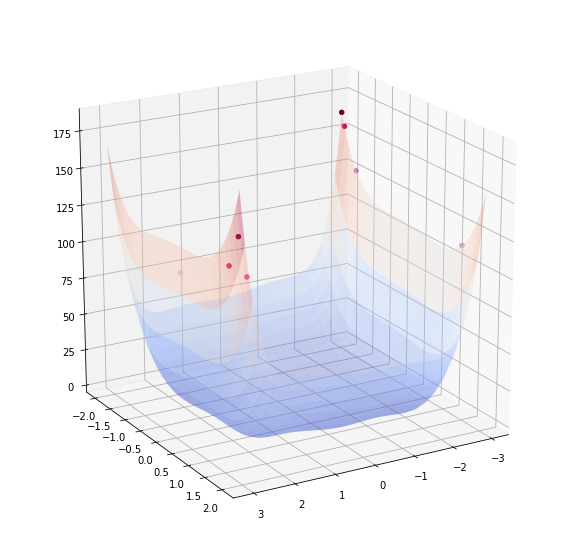

In [356]:
X,Y = ga_eval._mesh(xmin, xmax, ymin, ymax)
Z = np.zeros(np.asarray(X).shape)
for i, j in itertools.product(range(X.shape[0]), range(X.shape[1])):
    Z[i, j] = sixcamelback(np.array([X[i,j], Y[i,j]]))
print("Maximum found in mesh: " + str(Z.max()))
print("Minimum found in mesh: " + str(Z.min()))
fig = plt.figure(figsize=(10,10))
col1 = np.arange(len(xx))
ax.set_title("SA (T_max=10000, maximize) on Six Hump Camelback")
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, alpha=0.3)
ax.scatter(xx, yy, zz, c=col1, cmap='PuRd', marker='o', alpha=1)
ax.set_zlim(Z.min(), Z.max())
ax.view_init(20, 60)
plt.show()

In [362]:
xmin, xmax, ymin, ymax = -5, 5, -5, 5
sol_sa_himmelblau_max_v = simulated_annealing(xmin, xmax, ymin, ymax, himmelblau, T_max=10000, t=0, verbose=True)
population = initial_population(xmin, xmax, ymin, ymax, 5)
sol_ga_himmelblau_max_v = genetic_algorithm(population, himmelblau, 800, xmin, xmax, ymin, ymax, T=10000, verbose=True)

In [363]:
xx,yy,zz=[],[],[]
for i in range(len(sol_sa_himmelblau_max_v)):
    xx.append(sol_sa_himmelblau_max_v[i][0])
    yy.append(sol_sa_himmelblau_max_v[i][1])
    zz.append(himmelblau(sol_sa_himmelblau_max_v[i]))

In [364]:
print(zz)

[42.0000566093126, 116.06825992959108, 126.87739294368502, 128.84138673663503, 242.7242304885675, 278.99852016183803, 342.7054576778495, 455.86312290409325, 461.883870508509, 477.03256946058303, 542.852392639427, 671.4933466310433, 715.3962794155279, 789.8553099538178, 856.0171345767692]


Maximum found in mesh: 890.0
Minimum found in mesh: 0.0


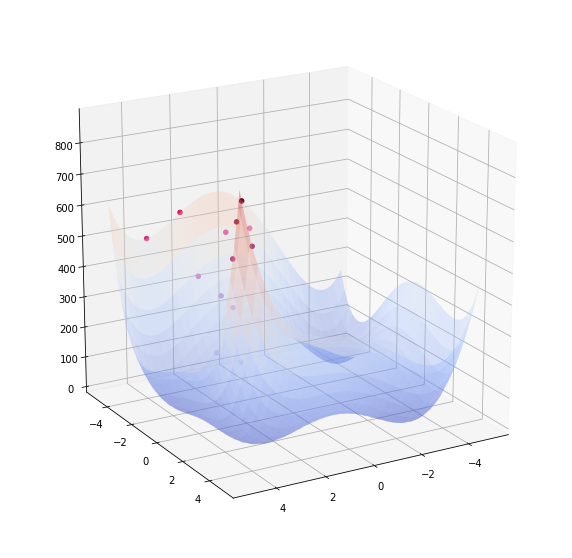

In [368]:
X,Y = ga_eval._mesh(xmin, xmax, ymin, ymax)
Z = np.zeros(np.asarray(X).shape)
for i, j in itertools.product(range(X.shape[0]), range(X.shape[1])):
    Z[i, j] = himmelblau(np.array([X[i,j], Y[i,j]]))
print("Maximum found in mesh: " + str(Z.max()))
print("Minimum found in mesh: " + str(Z.min()))
fig = plt.figure(figsize=(10,10))
col1 = np.arange(len(xx))
ax.set_title("SA (T_max=10000, maximize) on Six Hump Camelback")
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, alpha=0.3)
ax.scatter(xx, yy, zz, c=col1, cmap='PuRd', marker='o', alpha=1)
ax.set_zlim(Z.min(), Z.max())
ax.view_init(20, 60)
plt.show()

In [373]:
xmin, xmax, ymin, ymax = -5, 5, -5, 5
sol_sa_ackley_min_v = simulated_annealing(xmin, xmax, ymin, ymax, ackley, T_max=10000, t=0, verbose=True, maximize=False)
population = initial_population(xmin, xmax, ymin, ymax, 5)
sol_ga_ackley_min_v = genetic_algorithm(population, ackley, 12, xmin, xmax, ymin, ymax, T=10000, verbose=True, maximize=False)

In [378]:
xx,yy,zz,xg,yg,zg=[],[],[],[],[],[]
for i in range(len(sol_sa_ackley_min_v)):
    xx.append(sol_sa_ackley_min_v[i][0])
    yy.append(sol_sa_ackley_min_v[i][1])
    zz.append(ackley(sol_sa_ackley_min_v[i]))
for i in range(len(sol_ga_ackley_min_v)):
    xg.append(sol_ga_ackley_min_v[i][0])
    yg.append(sol_ga_ackley_min_v[i][1])
    zg.append(ackley(sol_ga_ackley_min_v[i]))

In [379]:
print(zz)

[10.849588025500296, 10.503394795831625, 9.34164645161615, 8.04625402939934, 7.6207371131971815, 7.488236291918689, 5.401252392524061, 4.5565096740032764, 4.413268416626398, 4.407521573955506, 4.196781009425127, 4.164307750043314, 3.660460953702181, 3.575976119544837, 2.6369203082331616]


In [383]:
print(zg)

[10.000990062935392, 10.43039040209696, 10.4303433177195, 10.4303433177195, 10.4303433177195, 10.4303433177195, 10.4303433177195, 10.4303433177195, 10.4303433177195, 10.4303433177195, 10.4303433177195, 10.4303433177195, 10.4303433177195, 10.4303433177195, 10.4303433177195, 10.292208947214945, 10.292208947214945, 10.292208947214945, 10.292208947214945, 10.292208947214945, 10.292208947214945, 10.292208947214945, 10.292208947214945, 10.292208947214945, 10.292208947214945, 10.292208947214945, 10.292208947214945, 10.292208947214945, 10.292208947214945, 10.292208947214945, 10.292208947214945, 9.981464327084234, 9.981464327084234, 9.981464327084234, 9.981464327084234, 7.249043002155348, 7.249043002155348, 7.249043002155348, 7.249043002155348, 7.249043002155348, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

Maximum found in mesh: 14.302605427560742
Minimum found in mesh: 0.0


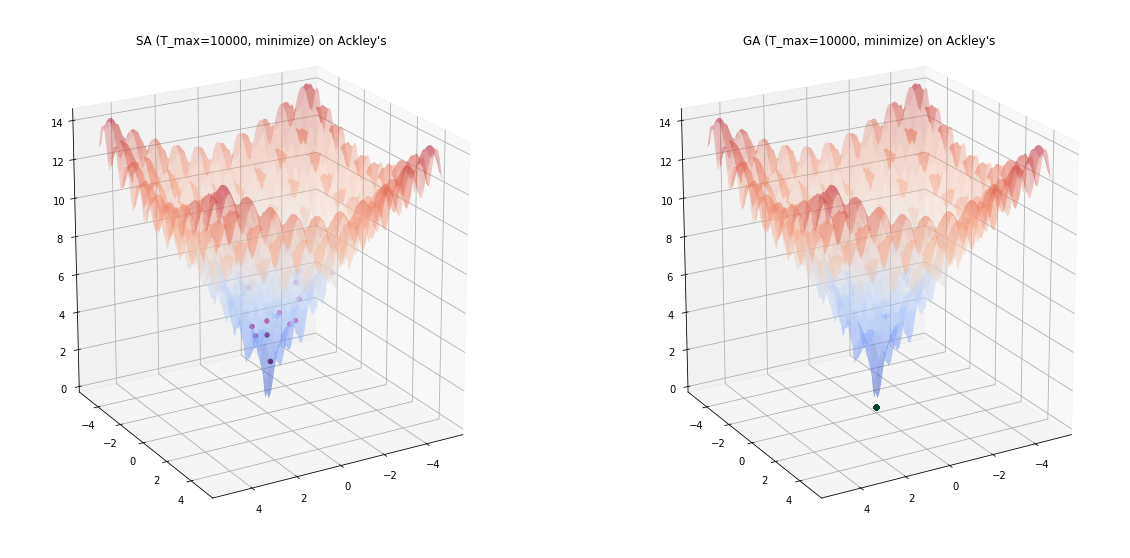

In [390]:
# Create Map
X,Y = ga_eval._mesh(xmin, xmax, ymin, ymax)
Z = np.zeros(np.asarray(X).shape)
for i, j in itertools.product(range(X.shape[0]), range(X.shape[1])):
    Z[i, j] = ackley(np.array([X[i,j], Y[i,j]]))
print("Maximum found in mesh: " + str(Z.max()))
print("Minimum found in mesh: " + str(Z.min()))
fig = plt.figure(figsize=(20,10))
col1 = np.arange(len(xx))
col2 = np.arange(len(xg))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_title("SA (T_max=10000, minimize) on Ackley's")
#ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, alpha=0.3)
ax.scatter(xx, yy, zz, c=col1, cmap='PuRd', marker='o', alpha=1)
ax.set_zlim(Z.min(), Z.max())
ax.view_init(20, 60)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_title("GA (T_max=10000, minimize) on Ackley's")
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, alpha=0.3)
ax.scatter(xg, yg, zg, c=col2, cmap='YlGn', marker='o', alpha=1)
ax.set_zlim(Z.min(), Z.max())
ax.view_init(20, 60)
plt.show()

In [413]:
xmin, xmax, ymin, ymax = -10, 10, -10, 10
sol_sa_holders_min_v = simulated_annealing(xmin, xmax, ymin, ymax, holders, T_max=10000, t=0, verbose=True, maximize=False)
population = initial_population(xmin, xmax, ymin, ymax, 5)
sol_ga_holders_min_v = genetic_algorithm(population, holders, 16, xmin, xmax, ymin, ymax, T=10000, verbose=True, maximize=False)

In [414]:
xx,yy,zz,xg,yg,zg=[],[],[],[],[],[]
for i in range(len(sol_sa_holders_min_v)):
    xx.append(sol_sa_holders_min_v[i][0])
    yy.append(sol_sa_holders_min_v[i][1])
    zz.append(holders(sol_sa_holders_min_v[i]))
for i in range(len(sol_ga_holders_min_v)):
    xg.append(sol_ga_holders_min_v[i][0])
    yg.append(sol_ga_holders_min_v[i][1])
    zg.append(holders(sol_ga_holders_min_v[i]))

In [415]:
print(zz)

[-2.4713250900982957, -2.534020317405595, -2.698784084627165, -2.7413270921094233, -2.9603503560925826, -3.5734143949425947, -4.368022074666092, -5.936294992514047, -6.150168500454304, -9.234510340193973, -9.77591566464387, -18.905807828894794]


In [416]:
print(zg)

[-10.702545753079406, -10.702545753079406, -10.702545753079406, -10.702545753079406, -10.702545753079406, -10.702545753079406, -10.702545753079406, -10.763721613208226, -10.763721613208226, -10.763721613208226, -10.763721613208226, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.763781220609493, -10.76378122

Maximum found in mesh: -0.0
Minimum found in mesh: -19.136511921499274


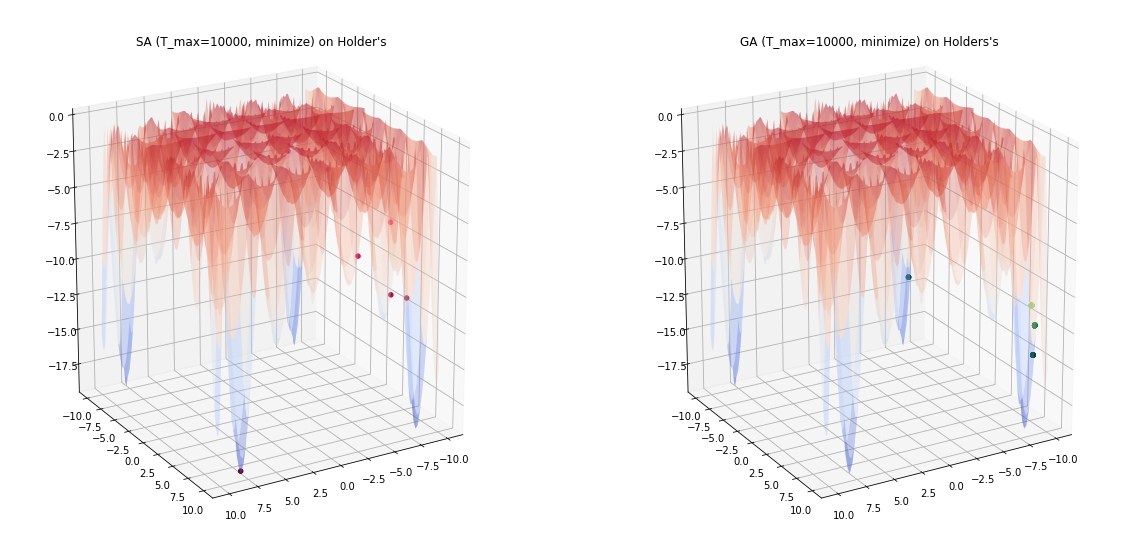

In [417]:
# Create Map
X,Y = ga_eval._mesh(xmin, xmax, ymin, ymax)
Z = np.zeros(np.asarray(X).shape)
for i, j in itertools.product(range(X.shape[0]), range(X.shape[1])):
    Z[i, j] = holders(np.array([X[i,j], Y[i,j]]))
print("Maximum found in mesh: " + str(Z.max()))
print("Minimum found in mesh: " + str(Z.min()))
fig = plt.figure(figsize=(20,10))
col1 = np.arange(len(xx))
col2 = np.arange(len(xg))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_title("SA (T_max=10000, minimize) on Holder's")
#ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, alpha=0.3)
ax.scatter(xx, yy, zz, c=col1, cmap='PuRd', marker='o', alpha=1)
ax.set_zlim(Z.min(), Z.max())
ax.view_init(20, 60)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_title("GA (T_max=10000, minimize) on Holders's")
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, alpha=0.3)
ax.scatter(xg, yg, zg, c=col2, cmap='YlGn', marker='o', alpha=1)
ax.set_zlim(Z.min(), Z.max())
ax.view_init(20, 60)
plt.show()